In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import sys

Fluxo de funcionamento:
- Lê tabela que associa o nome da imagem com a legenda
- Separa os dados de treino, validação e teste
- Constrói vocabulário apenas com as legendas de treinamento
- Instancia um dataset e dataloader para treino, validação e teste 

In [17]:
# Adiciona o diretório pai (raiz do projeto) ao path do sistema
sys.path.append(os.path.abspath(".."))

# ativar autoreload -> capturar mudanças do código fonte
%load_ext autoreload
%autoreload 2

from src.dataset import Vocabulary, FlickrDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
df = pd.read_csv("../data/flickr8k_cleaned_data.csv")

# Primeiro split: Treino vs Resto (Validação + Teste)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Segundo split: Divide o resto entre Validação e Teste
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [19]:
train_captions = train_df['caption_clean'].tolist()

min_freq=1

vocab = Vocabulary(min_freq)
vocab.build_vocabulary(train_captions)

print(f"Vocabulário criado com {len(vocab)} tokens")

Vocabulário criado com 7560 tokens


In [20]:
caption_example = train_captions[0]
caption_tokenized = vocab.tokenize(caption_example)

print(f"Legenda original: {caption_example}")
print(f"Após tokenização: {caption_tokenized}")

Legenda original: a boy holding a lightsaber jumps in the middle of the street
Após tokenização: [4, 5, 6, 4, 7, 8, 9, 10, 11, 12, 10, 13]


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),         
    # Média e desvio padrão para cada canal de cor do imagenet
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

batch_size = 4
max_tokens = 25

train_dataset = FlickrDataset("../data/Images", train_df, vocab, transform=transform, max_tokens=max_tokens)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = FlickrDataset("../data/Images", val_df, vocab, transform=transform, max_tokens=max_tokens)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FlickrDataset("../data/Images", test_df, vocab, transform=transform, max_tokens=max_tokens)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [22]:
dataiter = iter(train_loader)
images, captions = next(dataiter)

# Verificar as dimensões
print(f"Shape das imagens: {images.shape}")   # Esperado: [4, 3, H, W]
print(f"Shape das legendas: {captions.shape}") # Esperado: [4, max_tokens]

print(f"\nPrimeira legenda do batch:\n{captions[0]}")

Shape das imagens: torch.Size([4, 3, 224, 224])
Shape das legendas: torch.Size([4, 25])

Primeira legenda do batch:
tensor([  1,   4,  37, 228,   4,  38, 225,  56, 322, 986, 182, 198,   4,  29,
          2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])


In [23]:
def show_img_and_cap(images, captions, vocab):
    # Valores de desnormalização baseados no ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, (img, cap) in enumerate(zip(images, captions)):\
        # Desnormaliza para voltar aos tons originais
        img_vis = img * std + mean 

        # Permuta de (C, H, W) para (H, W, C) para o Matplotlib
        img_plot = img_vis.permute(1, 2, 0).numpy()
        img_plot = np.clip(img_plot, 0, 1)

        tokenized_ids = cap.tolist()

        # Legenda Destokenizada (Texto legível)
        # Filtramos tokens especiais para a leitura ficar mais fluida
        ignore_tokens = [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]
        destokenized_words = [vocab.itos[token.item()] for token in cap if token.item() not in ignore_tokens]
        destokenized_cap = " ".join(destokenized_words)

        # Exibição dos resultados
        print(f"--- Exemplo {i+1} ---")
        print(f"Tokenizada (IDs): {tokenized_ids}")
        print(f"Destokenizada: {destokenized_cap}")
        
        plt.figure(figsize=(5, 4))
        plt.imshow(img_plot)
        plt.title(f"Amostra {i+1}", fontsize=10)
        plt.axis('off')
        plt.show()

--- Exemplo 1 ---
Tokenizada (IDs): [1, 4, 37, 228, 4, 38, 225, 56, 322, 986, 182, 198, 4, 29, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a man wearing a white shirt and jeans attempts to climb a rock


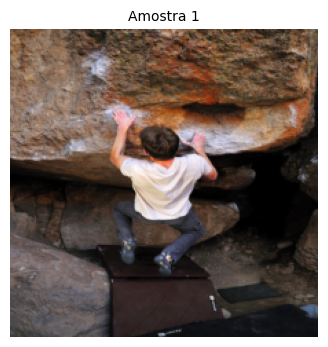

--- Exemplo 2 ---
Tokenizada (IDs): [1, 4, 43, 215, 17, 9, 4, 823, 308, 155, 69, 334, 770, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a small child is in a grassy field near an old structure


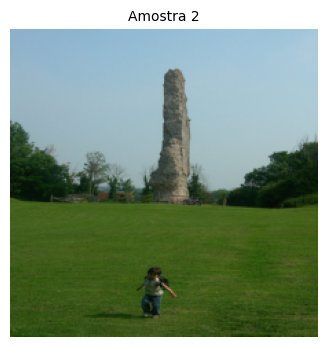

--- Exemplo 3 ---
Tokenizada (IDs): [1, 73, 37, 83, 2224, 4, 984, 314, 4, 414, 33, 111, 802, 21, 3175, 202, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: two man are paddling a kayak along a river with green trees on either side


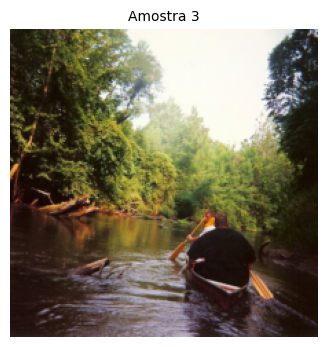

--- Exemplo 4 ---
Tokenizada (IDs): [1, 4, 775, 2579, 191, 556, 4, 132, 511, 1252, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a security guard standing beside a bright orange advertisement


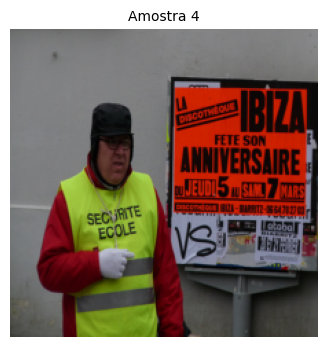

In [24]:
show_img_and_cap(images, captions, vocab)